# Netflix Movies and TV Shows Analysis

## Description

This dataset contains...

## Loading the data

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from wordcloud import (
    STOPWORDS,
    WordCloud
)
pyo.init_notebook_mode()

In [102]:
df = pd.read_csv('../data/netflix_titles.csv')
df.head()

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   
3  80058654  TV Show         Transformers: Robots in Disguise   
4  80125979    Movie                             #realityhigh   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   
3                       NaN   
4          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   
3                             United States  September 8, 2018          2016   
4                             United States  September 8, 2017          2017   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   
3     TV-Y7  1 Season                            Kids' TV   
4     TV-14    99 min                            Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...  
3  When a prison ship crash unleashes hundreds of...  
4  When nerdy high schooler Dani finally attracts...

### Basic Information

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


Given that `describe` doesn't calculate the number of unique values for numerical columns, we can print it ourselves:

In [104]:
df.nunique()

show_id         6234
type               2
title           6172
director        3301
cast            5469
country          554
date_added      1524
release_year      72
rating            14
duration         201
listed_in        461
description     6226
dtype: int64

## Data Transformation
### Missing Data Analysis

We begin our analysis by determining the number of rows with holes for each column:

In [105]:
df.isna().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

As we can see, we have missing values for:
* `director`: we won't be using it, so we'll discard it.
* `cast`: we won't be using it, so we'll discard it.
* `country`: we'll fill missing values here with the `mode`.
* `date_added`: if you look closely, you'll notice that it's safe to do a `ffill`. Plus, the rows with missing values for
this column are the last in the dataset.
* `rating`: given that there are only 10 empty values. I decided to google the corresponding ratings.

In [106]:
# Dropping cast and director.
df.drop(['director', 'cast'], axis=1, inplace=True)
# Filling the country column with the mode
df['country'].fillna(df['country'].mode()[0], inplace=True)
# Filling the date_added with forward propagation
df['date_added'] = df['date_added'].ffill()

In [107]:
replacements = {
    211: 'TV-MA',
    2411: 'PG-13',
    3288: 'TV-MA',
    4056: 'TV-MA',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-MA',
    5234: 'TV-MA',
    6231: 'TV-Y'
}

for show_id, rating in replacements.items():
    df.iloc[show_id, 6] = rating

We can check for missing data once more to confirm we no longer have empty values.

In [108]:
df.isna().sum()

show_id         0
type            0
title           0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

### Dropping additional columns

We now proceed to drop some other columns that we are not going to need for our process.

In [109]:
df.drop(['listed_in', 'description'], axis=1, inplace=True)

### Using `show_id` as index
As the `show_id` column doesn't include duplicates, we can well use it as the index of the `DataFrame`.

In [110]:
df.set_index('show_id', inplace=True)

### Duplicated Data Analysis

Let's check for duplicated rows:

In [111]:
df[df.duplicated()]

type   title country     date_added  release_year rating duration
show_id                                                                     
81072516  Movie  Sarkar   India  March 2, 2019          2018  TV-MA  162 min

As we can see, there's in fact, a duplicated record. We can print the duplicates just to corroborate that nothing
odd is going on:

In [112]:
df[df['title'] == 'Sarkar']

type   title country     date_added  release_year rating duration
show_id                                                                     
81075235  Movie  Sarkar   India  March 2, 2019          2018  TV-MA  162 min
81072516  Movie  Sarkar   India  March 2, 2019          2018  TV-MA  162 min

Having checked that both rows are actually identical (except for the `show_id`, obviously), we can delete
the duplicated row.

In [113]:
df.drop_duplicates(inplace=True)

### Converting values for `date_added` to Dates
If you take a look at the content of the `date_added` column you'll see that it contains dates in a variety
of formats. Lucky for us, `Pandas` can deal create Datetime objects out of all of them:

In [114]:
df['date_added'] = pd.to_datetime(df['date_added'])

### Converting `type` into a Categorical type
This column contains two possible values. Although it's not really needed for our analysis, we can transform this column
into a categorical one.

In [115]:
df['type'] = pd.Categorical(df['type'])

### Working with `country` (segregating american content)

If we explore the `country` column, we'll see that it has 544 different values:

In [116]:
df['country'].nunique()

554

We will also notice that roughly half of the rows contain the string "United States" in `country`.

In [117]:
len(df[df['country'].str.contains('United States')].index)

3086

Therefore, we can add a boolean column `american` to flag content produced, at least partially, by America.

In [118]:
df['american'] = df.apply(lambda row: 'United States' in row['country'], axis=1)

### Extracting `month` and `year` from `date_added`

Having parsed `date_added` to Datetime, we can create additional columns for the `month` and `year` to allow for additional
analysis in a convinient way.

In [119]:
df['month_added'] = pd.DatetimeIndex(df['date_added']).month
df['year_added'] = pd.DatetimeIndex(df['date_added']).year

### Working with `rating`
If we take a look at the `ratings` columns, we'll see that it contains 14 different values. They are:

In [120]:
df['rating'].unique()

array(['TV-PG', 'TV-MA', 'TV-Y7-FV', 'TV-Y7', 'TV-14', 'R', 'TV-Y', 'NR',
       'PG-13', 'TV-G', 'PG', 'G', 'UR', 'NC-17'], dtype=object)

As you may know, these _maturity ratings_ are earned based on the kind of content of the show, and they stipulate the recommended age for viewers.
Based on the information found on the [Amazon's Help & Customer Service](https://www.amazon.com/gp/help/customer/display.html?nodeId=G2C2CPZWGZWHZ42J) site,
we can map ratings like this:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rating</th>
      <th>Age Restriction</th>
    </tr>
  </thead>
  <tbody>
<tr><td>TV-PG</td><td>7</td></tr>
<tr><td>TV-MA</td><td>18</td></tr>
<tr><td>TV-Y7-FV</td><td>7</td></tr>
<tr><td>TV-Y7</td><td>7</td></tr>
<tr><td>TV-14</td><td>16</td></tr>
<tr><td>R</td><td>18</td></tr>
<tr><td>TV-Y</td><td>0</td></tr>
<tr><td>NR</td><td>18</td></tr>
<tr><td>PG-13</td><td>13</td></tr>
<tr><td>TV-G</td><td>0</td></tr>
<tr><td>PG</td><td>7</td></tr>
<tr><td>G</td><td>0</td></tr>
<tr><td>UR</td><td>18</td></tr>
<tr><td>NC-17</td><td>18</td></tr>
  </tbody>
</table>
</div>

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Name</th>
      <th>Age Restriction</th>
    </tr>
  </thead>
  <tbody>
<tr><td>Kids</td><td>0</td></tr>
<tr><td>Older Kids</td><td>7</td></tr>
<tr><td>Teens</td><td>13</td></tr>
<tr><td>Young Adults</td><td>16</td></tr>
<tr><td>Adults</td><td>18</td></tr>
  </tbody>
</table>
</div>

We can create additional `Series` for this information.

In [121]:
ratings_data = { 'TV-PG': 7,'TV-MA': 18,'TV-Y7-FV': 7,'TV-Y7': 7,
            'TV-14': 16,'R': 18,'TV-Y': 0,'NR': 18,'PG-13': 13,
            'TV-G': 0,'PG': 7,'G': 0,'UR': 18,'NC-17': 18}

ratings = pd.Series(ratings_data, name='age')
ratings

TV-PG        7
TV-MA       18
TV-Y7-FV     7
TV-Y7        7
TV-14       16
R           18
TV-Y         0
NR          18
PG-13       13
TV-G         0
PG           7
G            0
UR          18
NC-17       18
Name: age, dtype: int64

In [122]:
ages_data = {0: 'Kids', 7: 'Older Kids', 13: 'Teens', 16: 'Young Adults', 18: 'Adults'}
ages = pd.Series(ages_data, name='description')
ages

0             Kids
7       Older Kids
13           Teens
16    Young Adults
18          Adults
Name: description, dtype: object

We can now proceed to join both series to put together a temporary `DataFrame`. We also convert the columns to Categorical
because why not.

In [123]:
ratings_df = pd.merge(ratings, ages, left_on='age', right_index=True)
ratings_df['description'] = pd.Categorical(ratings_df['description'],
                                           categories=['Kids', 'Older Kids', 'Teens', 'Young Adults', 'Adults'],
                                           ordered=True)
ratings_df['age'] = pd.Categorical(ratings_df['age'], ordered=True)
ratings_df

age   description
TV-PG      7    Older Kids
TV-Y7-FV   7    Older Kids
TV-Y7      7    Older Kids
PG         7    Older Kids
TV-MA     18        Adults
R         18        Adults
NR        18        Adults
UR        18        Adults
NC-17     18        Adults
TV-14     16  Young Adults
TV-Y       0          Kids
TV-G       0          Kids
G          0          Kids
PG-13     13         Teens

We now merge our rating generated data into the main `DataFrame`. We will also rename the new columns with more appropriate names.

In [124]:
df = pd.merge(df, ratings_df, left_on='rating', right_index=True)
df.rename(columns={'age': 'recommended_age', 'description': 'rating_description'}, inplace=True)
df.head()


type                                    title  \
show_id                                                      
81145628    Movie  Norm of the North: King Sized Adventure   
80988892    Movie                                 Next Gen   
80095641    Movie                             Elstree 1976   
81016045    Movie                                  One Day   
80128317  TV Show                             The Eighties   

                                           country date_added  release_year  \
show_id                                                                       
81145628  United States, India, South Korea, China 2019-09-09          2019   
80988892              China, Canada, United States 2018-09-07          2018   
80095641                            United Kingdom 2016-09-06          2015   
81016045                                  Thailand 2018-09-05          2016   
80128317                             United States 2018-09-30          2016   

         rating  duration  american  month_added  year_added recommended_age  \
show_id                                                                        
81145628  TV-PG    90 min      True            9        2019               7   
80988892  TV-PG   106 min      True            9        2018               7   
80095641  TV-PG   102 min     False            9        2016               7   
81016045  TV-PG   135 min     False            9        2018               7   
80128317  TV-PG  1 Season      True            9        2018               7   

         rating_description  
show_id                      
81145628         Older Kids  
80988892         Older Kids  
80095641         Older Kids  
81016045         Older Kids  
80128317         Older Kids

## Descriptive Statistics

Having dropped columns we don't need, added some extra columns with information, enforced data types and removed duplicates,
our data is finally ready to start our analysis. Let's begin by printing some descriptive analytics.

### Statistics for Numerical Variables

In [125]:
df.describe().T

count         mean       std     min     25%     50%     75%  \
release_year  6233.0  2013.358575  8.812131  1925.0  2013.0  2016.0  2018.0   
month_added   6233.0     6.833146  3.620617     1.0     4.0     7.0    10.0   
year_added    6233.0  2017.976095  1.215370  2008.0  2017.0  2018.0  2019.0   

                 max  
release_year  2020.0  
month_added     12.0  
year_added    2020.0

### Statistic for Categorical Variables

In [126]:
df.describe(include=[object, 'category']).T

count unique            top  freq
type                6233      2          Movie  4264
title               6233   6172         Tunnel     3
country             6233    554  United States  2508
rating              6233     14          TV-MA  2031
duration            6233    201       1 Season  1321
recommended_age     6233      5             18  2766
rating_description  6233      5         Adults  2766

### Types

In [127]:
df.dtypes

type                        category
title                         object
country                       object
date_added            datetime64[ns]
release_year                   int64
rating                        object
duration                      object
american                        bool
month_added                    int64
year_added                     int64
recommended_age             category
rating_description          category
dtype: object

## Releases by type throughout the years

In [128]:
def group_and_count_by(column_names:list, reset_index:bool = True) -> pd.DataFrame:
    data = df.filter(column_names).reset_index().groupby(column_names).count().rename(columns={'show_id': 'count'})
    if reset_index:
        data = data.reset_index()
    return data.sort_values(by=['count'], ascending=False)

In [129]:
releases_by_year = group_and_count_by((['release_year', 'type']))

fig = px.bar(releases_by_year, x='release_year', y='count', color='type')
fig.show()

## Shows by Rating

In [130]:
shows_by_rating = group_and_count_by(['rating_description', 'type'])
fig = px.bar(shows_by_rating, x='rating_description', y='count', color='type', barmode='group')
fig.show()

In [131]:
def plot_pie(data, fig, row, col, top:int = -1):
    labels = data['labels']
    values = data['values']
    if top > 0:
        labels = data['labels'][:top]
        labels.loc[labels.index.max() + 1] = "Others"
        values = data['values'][:top]
        values.loc[values.index.max() + 1] = data['values'][top:].sum()
    fig.add_trace(
        go.Pie(labels=labels,
               values=values,
               name=data['name']),
        row, col
    )

def plot_pie_pair(data_a, data_b, title, top:int = -1):
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])
    plot_pie(data_a, fig, 1, 1, top)
    plot_pie(data_b, fig, 1, 2, top)
    fig.update_traces(hole=.4, hoverinfo="label+percent+name")
    fig.update_layout(
        title_text=title,
        annotations=[
            dict(text=data_a['name'], x=0.16
                 , y=0.5, font_size=12, showarrow=False),
            dict(text=data_b['name'], x=0.82, y=0.5, font_size=12, showarrow=False)
        ])
    fig.show()

In [132]:
ratings_tv_shows = shows_by_rating[shows_by_rating['type'] == 'TV Show']
ratings_movies = shows_by_rating[shows_by_rating['type'] == 'Movie']
data_a = {
    'labels': ratings_tv_shows['rating_description'],
    'values': ratings_tv_shows['count'],
    'name': "TV Shows"
}

data_b = {
    'labels': ratings_movies['rating_description'],
    'values': ratings_movies['count'],
    'name': "Movies"
}

plot_pie_pair(data_a, data_b, 'TV Shows and Movies')

In [133]:
shows_by_rating = group_and_count_by(['rating', 'type'])
ratings_tv_shows = shows_by_rating[shows_by_rating['type'] == 'TV Show']
ratings_movies = shows_by_rating[shows_by_rating['type'] == 'Movie']

data_a = {
    'labels': ratings_tv_shows['rating'],
    'values': ratings_tv_shows['count'],
    'name': "TV Shows"
}

data_b = {
    'labels': ratings_movies['rating'],
    'values': ratings_movies['count'],
    'name': "Movies"
}

plot_pie_pair(data_a, data_b, 'TV Shows and Movies', 5)

## Catalog updates through the years

In [139]:
catalog_updates = group_and_count_by(['year_added', 'type'])
fig = px.line(catalog_updates.sort_values(by=['year_added']), x="year_added", y="count", color='type')
fig.show()

## Word Cloud for `title`

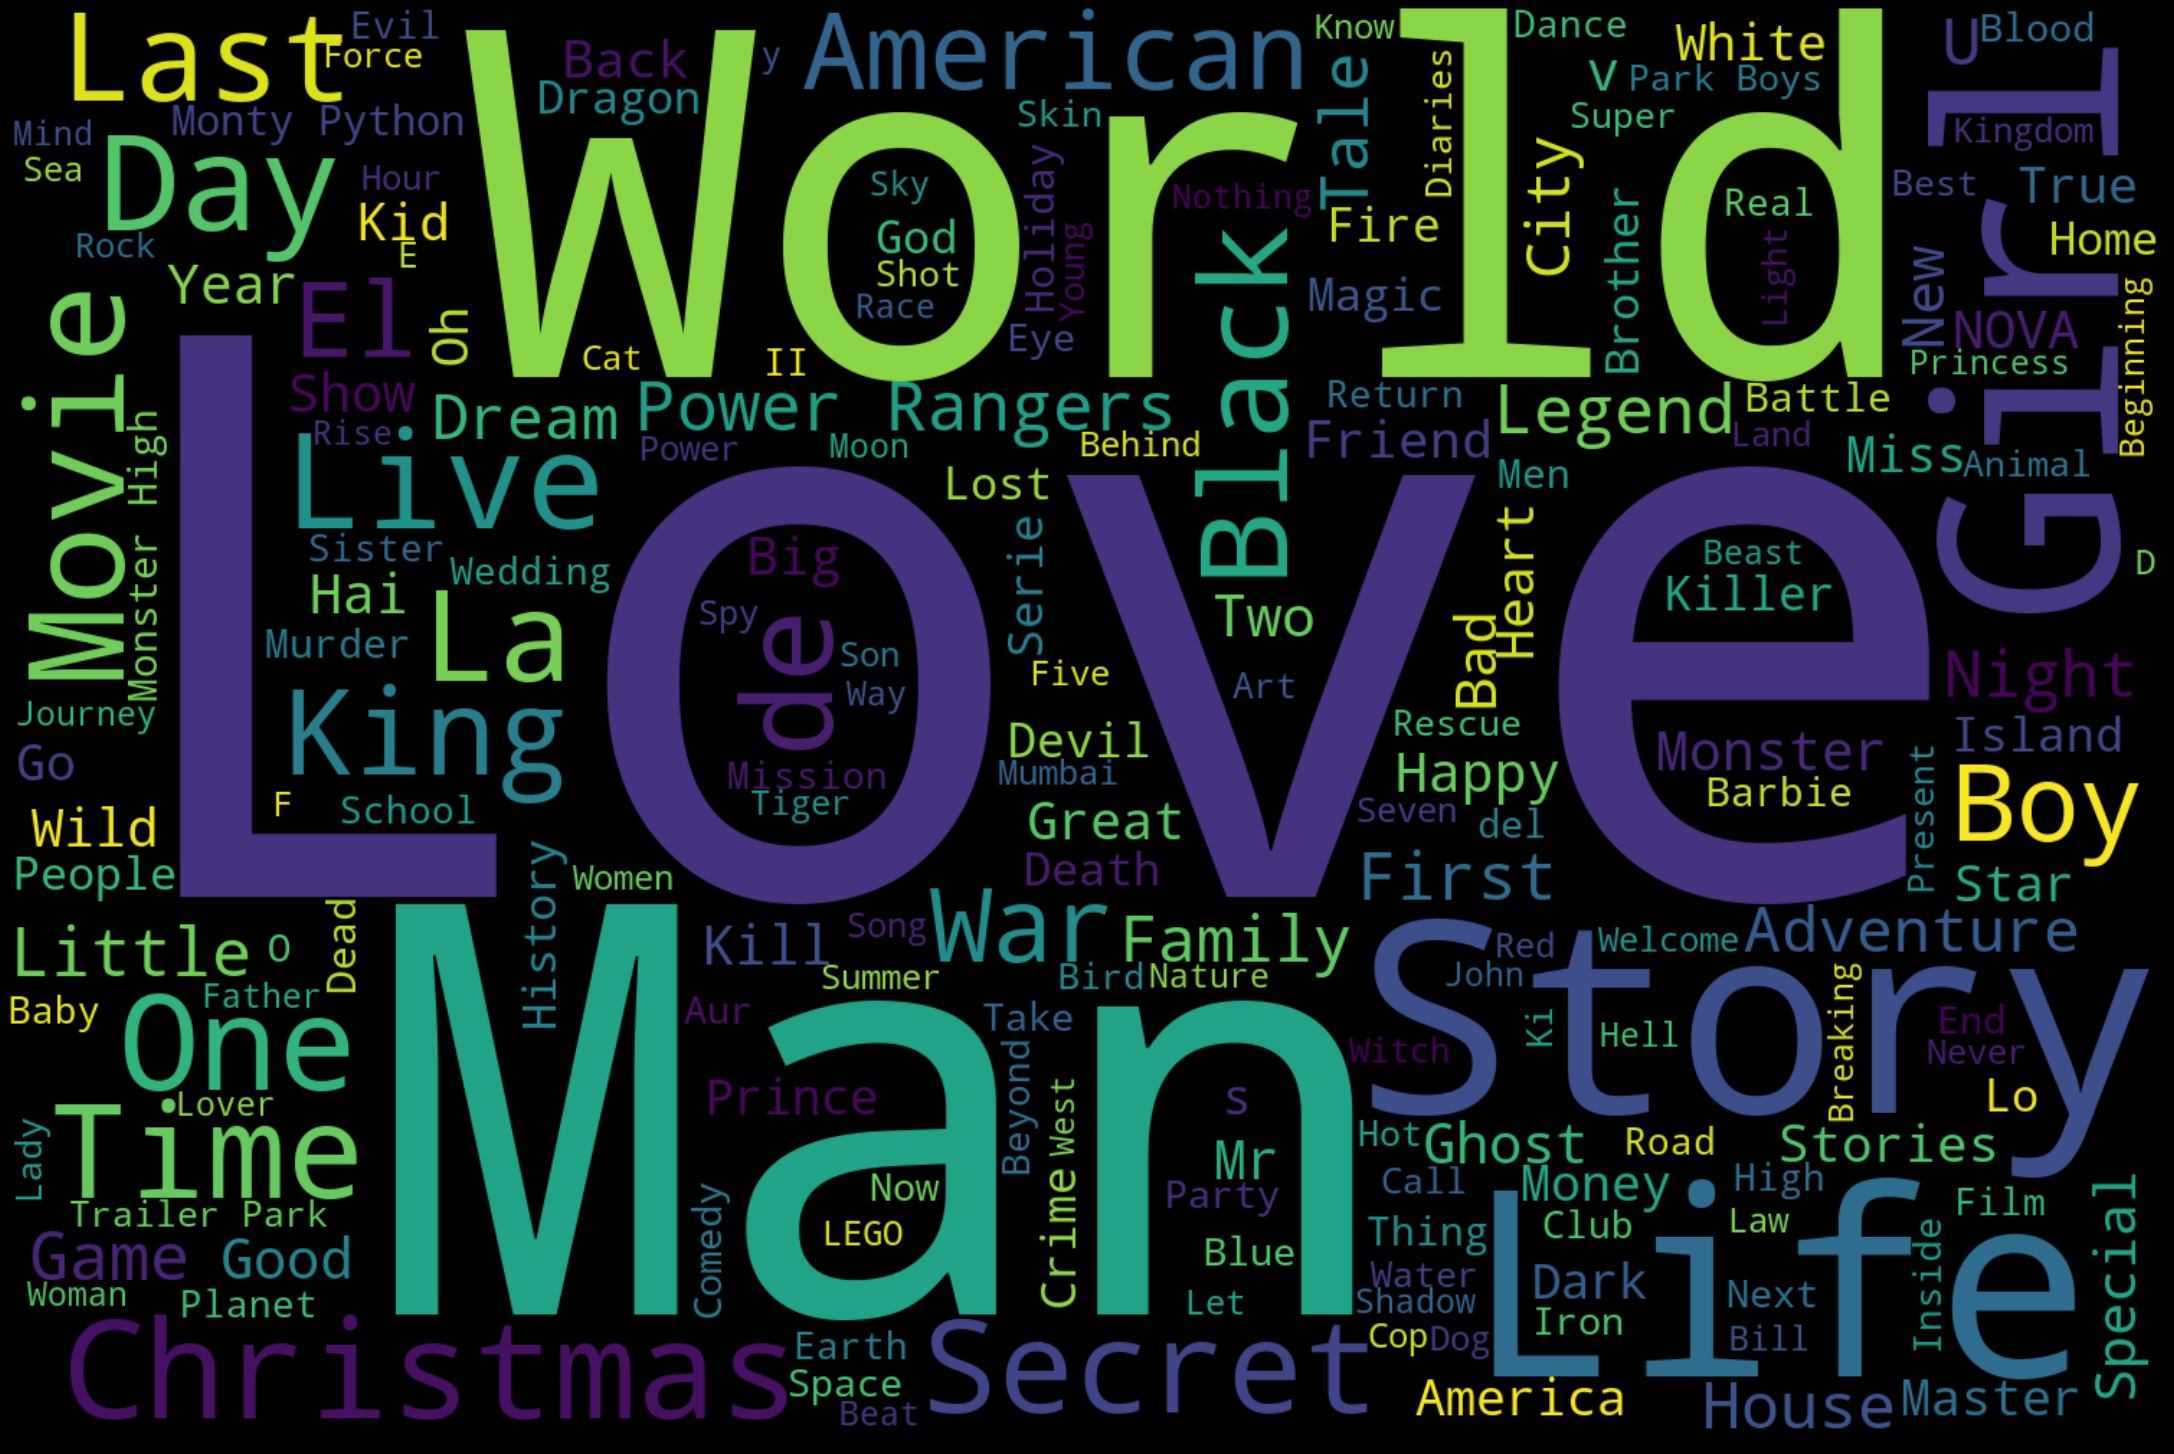

In [134]:
wordcloud = WordCloud(
    height = 1000,
    width = 1500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(' '.join(df['title'].values)))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()